# Wavelets

Para uma boa introdução à teoria de wavelets, leia o texto 
[Wavelets: uma introdução](https://rmu.sbm.org.br/wp-content/uploads/sites/27/2018/03/n33_Artigo02.pdf) 
por Paulo Cupertino de Lima, publicado na revista Matemática Universitária n33 (2002).


Iremos realizar aqui alguns exemplos da transformada wavelet discreta para melhor compreender seu funcionamento e aplicação.

## Exemplo 1

Vamos inicialmente verificar que, utilizando-se as médias e as diferenças, podemos criar representações de um sinal em diferentes resoluções. 

Para plotar os resultados, iremos utilizar a função ```stairs```, porém iremos fazer um *wrapper* sobre ela para poder criar um gráfico com a visualização desejada (veja a comparação abaixo).

In [1]:
function mystairs (n,x,p)
  if nargin > 1
     x = [x x(end)];
     n = [n 2*n(end)-n(end-1)];
     if nargin > 2,
       stairs (n, x, p);
     else
       stairs (n, x);
     endif
  else,
     x = [n n(end)];
     stairs (x);
  endif
endfunction

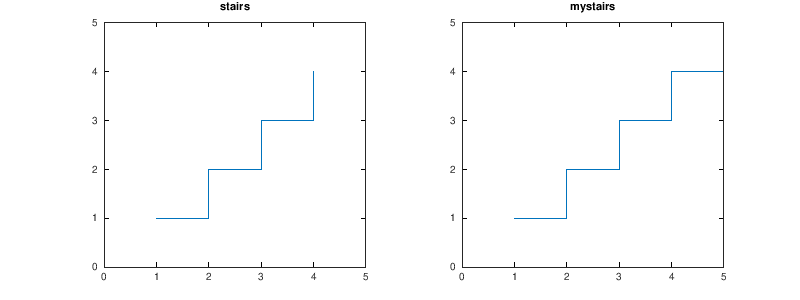

In [2]:
figure(1, 'position',[0,0,800,300]);
x = [1:4];
subplot(1,2,1); stairs(x); title('stairs'); xlim([0 5]); ylim([0 5]);
subplot(1,2,2); mystairs(x); title('mystairs'); xlim([0 5]); ylim([0 5]);

Vamos definir abaixo o sinal que iremos utilizar no primeiro exemplo.

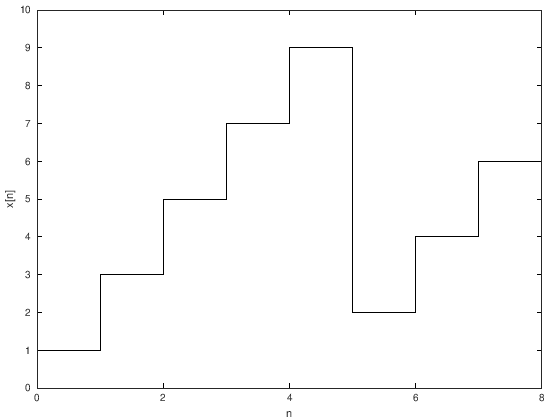

In [3]:
x = [1 3 5 7 9 2 4 6]; n = [0:length(x)-1];
mystairs(n,x,'k'); set(gca,'ytick',[0:10]); xlabel('n'); ylabel('x[n]'); ylim([0 10]);

Definimos uma função constante por partes em intervalos de comprimento igual a 1 (um). 

Vamos agora calcular a média e diferenças entre as amostras de $x[n]$ e fazer o gráfico das funções constantes por partes correspondentes.

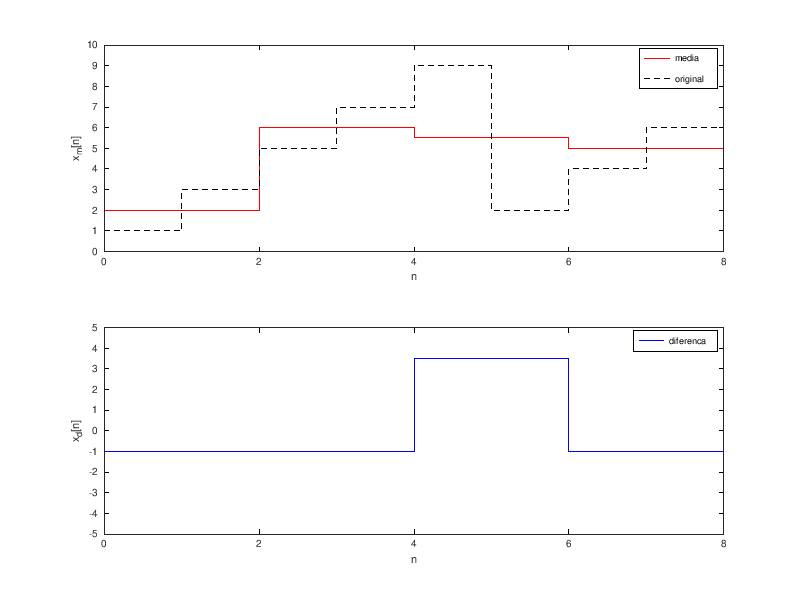

In [4]:
xm = (x(1:2:end-1) + x(2:2:end))/2; % media de cada duas amostras
xd = (x(1:2:end-1) - x(2:2:end))/2; % diferença de cada duas amostras
figure(1, 'position',[0,0,800,600]);

subplot(2,1,1); mystairs(n(1:2:end),xm,'r');
set(gca,'ytick',[0:10]); xlabel('n'); ylabel('x_m[n]'); ylim([0 10]);
hold on; mystairs(n,x,'k--'); legend({'media','original'});

subplot(2,1,2); mystairs(n(1:2:end),xd,'b'); 
set(gca,'ytick',[-5:5]); xlabel('n'); ylabel('x_d[n]'); ylim([-5 5]);
legend({'diferenca'});

Note que agora, $x_m[n]$ e $x_d[n]$ possuem metade das amostras e correspondem a funções constante por partes em intervalos de tamanho 2 (dois).

A partir de $x_m[n]$ e $x_d[n]$ podemos obter $x[n]$ novamente, basta somar e subtrair $x_d[n]$ a $x[n]$.

$x[n] = [1, 3, 5, 7, 9, 2, 4, 6]$

$x_m[n] = [2, 6, 5.5, 5]$ e $x_d[n] = [-1, -1, 4, -1]$.

Note que para obter $x[0]$ basta fazer $x_m[0] + x_d[0] = 2 - 1 = 1$;
para obter $x[1]$ basta fazer $x_m[0] - x_d[0] = 2 + 1 = 3$; e assim por diante.

Abaixo iremos reconstruir $x[n]$ utilizando $x_m[n]$ e $x_d[n]$:

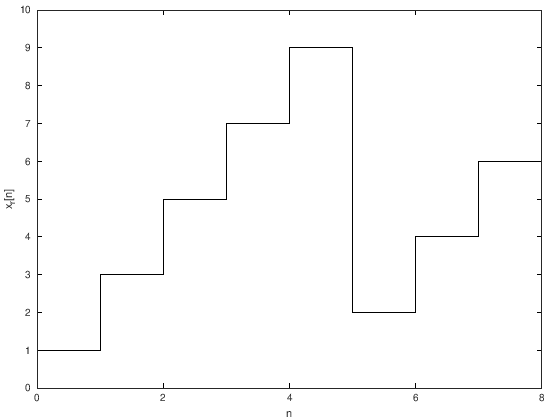

In [5]:
xr = [xm+xd ; xm-xd]; % reconstruçao de x
xr = xr(:)';
mystairs(n,xr,'k'); set(gca,'ytick',[0:10]); xlabel('n'); ylabel('x_r[n]');

## Exemplo 2

Neste exemplo iremos repetir o exemplo anterior, porém utilizaremos um filtro média móvel, seguido de downsample, para obter $x_m[n]$ e um filtro diferença móvel, seguido de downsample, para obter $x_d[n]$. Iremos também considerar que os sinais são periódicos, desta forma, iremos utilizar a convolução circular.

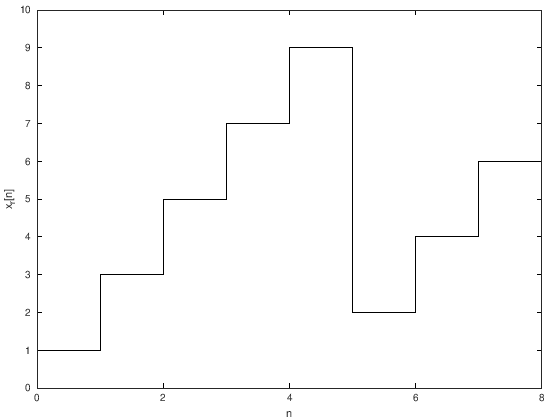

In [6]:
pkg load signal
N = length(x);
% decomposição
xm = downsample(cconv(x, [0.5  0.5], N), 2);
xd = downsample(cconv(x, [0.5 -0.5],N ), 2);
% reconstrução
xa = cconv(upsample(xm,2),[1 1],N);
xb = cconv(upsample(xd,2),[-1 1],N);
xr = shift(xa + xb,-1);

mystairs(n,xr,'k'); set(gca,'ytick',[0:10]); xlabel('n'); ylabel('x_r[n]');

## Exemplo 3

Iremos utilizar o que foi visto no exemplo anterior para criar uma função para realizar a decomposição e outra para realizar a reconstrução wavelet.

No exemplo ilustrativo anterior, fizemos a média móvel e diferença móvel. Estes filtros não satisfazem as propriedades para serem wavelets, mas são próximos da wavelet de Haar que utiliza os coeficientes $[\frac{\sqrt{2}}{2}, \frac{\sqrt{2}}{2}]$ e $[\frac{\sqrt{2}}{2}, -\frac{\sqrt{2}}{2}]$ para os filtros passa-baixas e passa-altas, respectivamente.

In [7]:
function g = h2g (h)
  N = length (h);
  g=[];
  for n=0:N-1,
    g(n+1) = (-1)^n * h(N-n);
  endfor;
endfunction 

function [low,high] = wavedec (x,h,g)
  % [low,high] = wavedec (x,h,g)
  % [low,high] = wavedec (x,h)
  % xd = wavedec (x,h)
  if nargin < 3, g = h2g (h); endif
  N = length(x);
  low  = downsample(cconv(x, h, N), 2);
  high = downsample(cconv(x, g, N), 2);
  if nargout < 2, low = [low high]; endif
endfunction

function x = waverec (low,high,h,g)
  % x = waverec (low,high,h,g)
  % x = waverec (low,high,h)
  % x = waverec (xd,h)
  if nargin < 3, h = high; high = low(length(low)/2+1:end); low = low(1:length(low)/2); endif
  if nargin < 4, g = h2g (h); endif
  
  N = 2*length(low);
  xa = cconv(upsample(low,2),h,N);
  xb = cconv(upsample(high,2),fliplr(g),N);
  x = shift(xa + xb,-1);
endfunction

Após definir a função para decomposição e reconstrução, vamos revisitar o exemplo anterior utilizando estas funções e a wavelet de Haar.

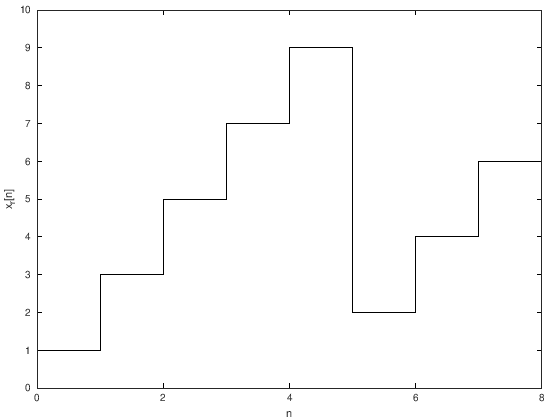

In [8]:
h = sqrt(2)/2 * ones(1,2);

x = [1 3 5 7 9 2 4 6];
n = [0:length(x)-1];
[low,high] = wavedec (x,h);
xr = waverec (low,high,h);

mystairs(n,xr,'k'); set(gca,'ytick',[0:10]); xlabel('n'); ylabel('x_r[n]');

## Exemplo 4

Vamos agora apresentar um exemplo de decomposição e reconstrução utilizando wavelets aplicado em uma imagem.

Utilizando as funções ```wavedec``` e ```waverec```, definidas acima, iremos implementar as funções ```wavedec2``` e ```waverec2``` para realizar o processamento em 2 dimensões, que será a base para o processo de decomposição/reconstrução não-padrão (onde é feito sob as linhas e colunas alternadamente).

In [9]:
pkg load image

function XD = wavedec2 (X,h,g)
  if nargin < 3, g = h2g (h); endif
  wdec = @(block_struct) wavedec(block_struct,h,g);
  % ao longo das linhas
  XD_l = blockproc (X,[1 size(X,2)],wdec);
  % ao longo das coulnas
  XD_c = blockproc (XD_l',[1 size(X,1)],wdec);
  XD = XD_c';
endfunction

function X = waverec2 (XD,h,g)
  if nargin < 3, g = h2g (h); endif
  wrec = @(block_struct) waverec(block_struct(1:length(block_struct)/2),
                                block_struct(length(block_struct)/2+1:length(block_struct)),
                                h,g);
  % ao longo das colunas
  X_c = blockproc (XD',[1 size(XD,1)],wrec);
  % ao longo das linhas
  X = blockproc (X_c',[1 size(XD,2)],wrec);
endfunction

Para este exemplo, iremos utilizar a imagem de teste [Lena](https://en.wikipedia.org/wiki/Lenna).

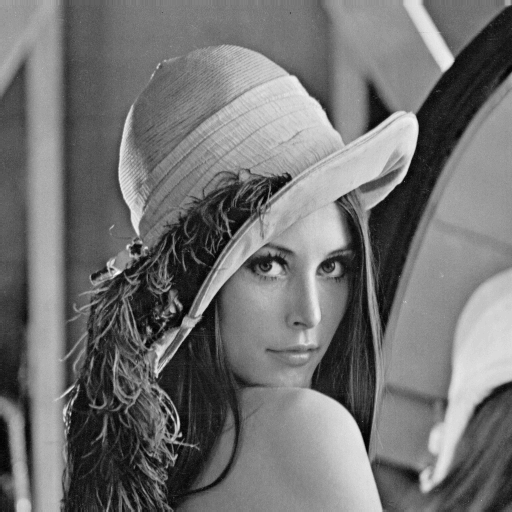

In [10]:
X = imread('imgs/lena.png');
X = rgb2gray(X);
imshow(X);

Agora iremos aplicar a função ```wavedec2``` definida acima e visualizar o resultado.

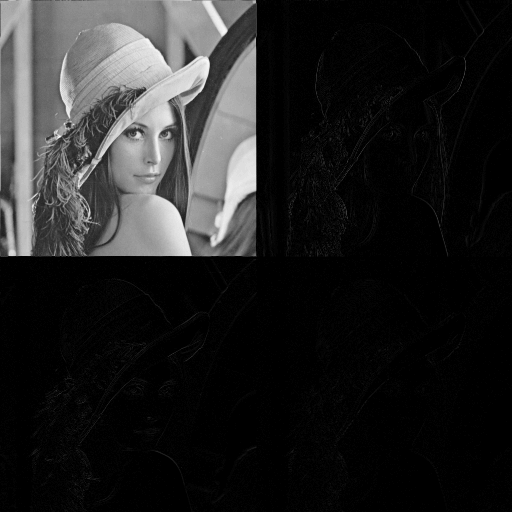

In [11]:
XD = wavedec2 (X,h);
imagesc(abs(XD));
colormap('gray');

Observe o resultado acima. Obtivemos uma versão de baixa resolução da imagem (no quadrante 1,1) e três versões com detalhes de alta-frequência, com valores próximos a zero (preto). A seguir, vamos analizar os histogramas: da imagem original, da versão de baixa resolução e dos detalhes (alta-frequencia).

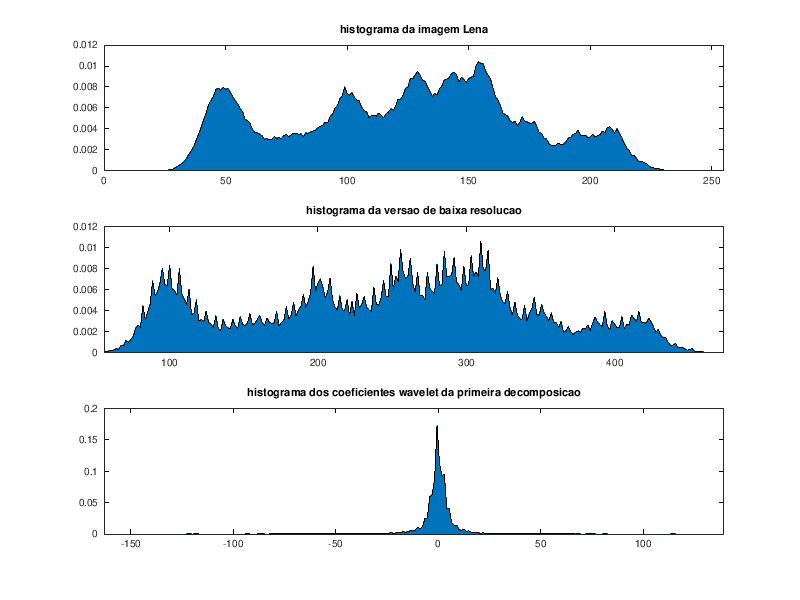

In [12]:
figure(1, 'position',[0,0,800,600]);
subplot(3,1,1);
hx = hist(X(:),[0:255]);
area([0:255],hx./sum(hx)); xlim([0 255]);
title('histograma da imagem Lena');
subplot(3,1,2);
xl = real(XD(1:size(XD,1)/2,1:size(XD,2)/2));
xl = xl(:);
vl = linspace(min(xl),max(xl),256);
hxl = hist(xl,vl);
area(vl,hxl./sum(hxl)); xlim([min(xl) max(xl)]);
title('histograma da versao de baixa resolucao');
subplot(3,1,3);
xd = real([XD(:,size(XD,2)/2+1:size(XD,2)); XD(1:size(XD,2)/2,size(XD,1)/2+1:size(XD,1))]);
xd = xd(:);
vd = linspace(min(xd),max(xd),256);
hxd = hist(xd,vd);
area(vd,hxd./sum(hxd)); xlim([min(xd) max(xd)]);
title('histograma dos coeficientes wavelet da primeira decomposicao');

Note que grande parte dos coeficientes wavelets (alta-frequência) são próximos de zero e assim agregam pouca informação do sinal. 

Vamos abaixo reconstruir a imagem. Faça um teste descartando os coeficientes de menor energia e verifique o resultado (nota: o [JPEG 2000](https://en.wikipedia.org/wiki/JPEG_2000) utiliza um [quantizador escalar com zona morta](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Dead-zone_quantizers) para quantizar estes coeficientes).

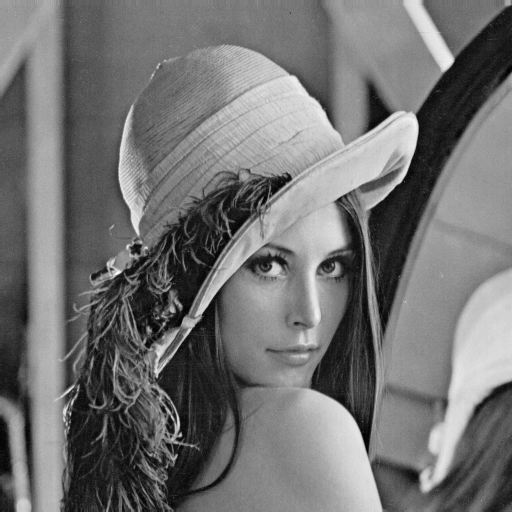

In [13]:
Xr = waverec2 (XD,h);
imshow(real(Xr));

In [14]:
function E = mse(X,Y)
  X = double(X); Y = double(Y);
  e = (X - Y).^2;
  e = e(:);
  E = sum(e)/length(e);
endfunction

printf('O erro médio quadrático na reconstrução da imagem foi de %.3f.\n', mse (X,Xr));


O erro médio quadrático na reconstrução da imagem foi de 0.000.


Vamos agora realizar a decomposição não-padrão completa da imagem e a reconstrução. Para tanto criamos as funções ```wavedec2full``` e ```waverec2full``` abaixo:

In [15]:
function XD = wavedec2full (X,h,g)
   l = log2(size(X));
   if any(l - floor(l) != 0), error('Size of X must be a power of 2!'); endif 
   if all(mod(size(X),2) == 0), 
     if nargin < 3, g = h2g (h); endif
     XD = wavedec2 (X,h,g);
     sD = size(XD);
     XD(1:sD(1)/2,1:sD(2)/2) = wavedec2full (XD(1:sD(1)/2,1:sD(2)/2),h,g);
   else,
     XD = X;
   endif
endfunction


function X = waverec2full (XD,h,g)
   if nargin < 3, g = h2g (h); endif
   sD = size(XD);
   if all(sD > 1), 
     XD(1:sD(1)/2,1:sD(2)/2) = waverec2full (XD(1:sD(1)/2,1:sD(2)/2),h,g);
     X = waverec2 (XD,h,g);
   else,
     X = XD;
   endif
endfunction

Vamos agora aplicá-las à imagem da Lena e mostrar o histograma dos coeficientes wavelets.

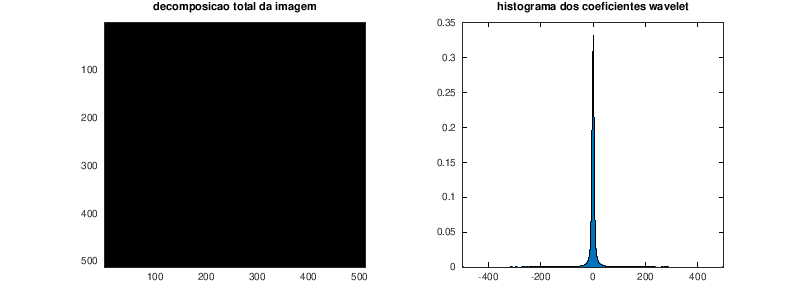

In [16]:
XD = wavedec2full (X,h);

figure(1, 'position',[0,0,800,300]);
subplot(1,2,1);
imagesc(abs(XD));
colormap('gray');
title('decomposicao total da imagem');

subplot(1,2,2);
xl = XD(:);
xl = sign(real(xl)) .* abs(xl);
limx = [-500, 500];
vl = linspace(limx(1),limx(2),256);
hxl = hist(xl,vl);
area(vl,hxl./sum(hxl)); xlim(limx);
title('histograma dos coeficientes wavelet');

Observe que grande parte dos coeficientes são valores pequenos, próximo de zero, carregando portanto pouca energia do sinal. Para a compressão de imagem podemos realizar a quantização destes coeficientes. 

Abaixo apresentamos o resultado da reconstrução.

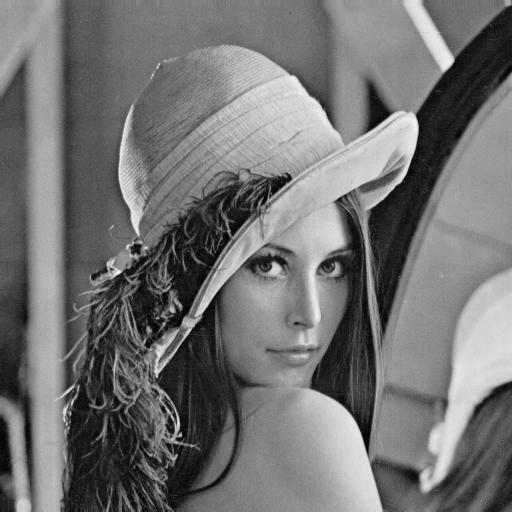

In [17]:
Xr = waverec2full (XD,h);
imshow(real(Xr));

Como nenhum coeficiente foi descartado, obtemos na reconstrução a mesma imagem (a menos de erros numéricos).

Faça a quantização dos coeficientes wavelets e reconstrua a imagem. Verifique o efeito desta quantização e estime o fator de compressão. Para a compressão podemos ainda utilizar RLE e codificadores de entropia com os dados da saída do quantizador, aumentando ainda mais o fator de compressoa.